# Setup

Get dataset:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp drive/MyDrive/clean_dataset.csv ./

Necessary imports:

In [3]:
# Necessary Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split

# Cleaning The Dataset



We start with a cell for helper function definitions. That way, when we change a function, rerunning the cell won't give us any issues by itself.

In [4]:
# (Given to us in challenge_basic.py)
def to_numeric(s):
    """Converts string `s` to a float.

    Invalid strings and NaN values will be converted to float('nan').
    """

    if isinstance(s, str):
        s = s.replace(",", '')
        s = pd.to_numeric(s, errors="coerce")
    return float(s)


# (Given to us in challenge_basic.py)
def get_number_list(s):
    """Get a list of integers contained in string `s`
    """
    return [int(n) for n in re.findall("(\d+)", str(s))]


# (Given to us in challenge_basic.py)
def get_number_list_clean(s):
    """Return a clean list of numbers contained in `s`.

    Additional cleaning includes removing numbers that are not of interest
    and standardizing return list size.
    """

    n_list = get_number_list(s)
    n_list += [-1]*(6-len(n_list))
    return n_list


# (Given to us in challenge_basic.py)
def get_number(s):
    """Get the first number contained in string `s`.

    If `s` does not contain any numbers, return -1.
    """
    n_list = get_number_list(s)
    return n_list[0] if len(n_list) >= 1 else -1


# (Given to us in challenge_basic.py)
def find_area_at_rank(l, i):
    """Return the area at a certain rank in list `l`.

    Areas are indexed starting at 1 as ordered in the survey.

    If area is not present in `l`, return -1.
    """
    return l.index(i) + 1 if i in l else 0


# (Given to us in challenge_basic.py)
def cat_in_s(s, cat):
    """Return if a category is present in string `s` as an binary integer.
    """
    return int(cat in s) if not pd.isna(s) else 0


def filter_string(input_string):
  """
    Filter out unwanted characters from quotes.

    NOTE: Currently removes all punctuation, turns any multi-line quotes into
    space separated ones, then manually removes carriage returns, form feeds,
    and tabspaces. Final result is lowercase.
  """
  if not isinstance(input_string, str):
    input_string = str(input_string)

  # Our regular expression
  pattern = r'[a-zA-Z\s\d]'

  # Get all characters
  filtered_characters = re.findall(pattern, input_string)

  # Join the extracted characters to form the filtered string
  filtered_string = ''.join(filtered_characters)

  # Remove carriage return, tabspace, form feed
  filtered_string = filtered_string.replace('\r','')
  filtered_string = filtered_string.replace('\t','')
  filtered_string = filtered_string.replace('\f','')

  # Sub any amount of newlines with a single space
  filtered_string = re.sub(r'\n+', " ", filtered_string)

  # Final result will be lowercase and have no trailing whitespace
  return filtered_string.lower().strip()


def clean_q6(row):
  """
    Get scores for each entry in Q6 and assign to corresponding position.

    NOTE: Positions are currently hard-coded in the same order as they appear
    in the CSV. Missing rankings are zeroes, duplicate rankings are kept as is.
  """
  res = np.array([0,0,0,0,0,0])  # To change value of null-entry, do it here

  # Split string of comma-separated scores
  items = row.split(',')

  # Loop through each score, then if the score is not blank, add it to array
  i = 0
  for item in items:
    _, v = item.split("=>")
    if v:
      res[i] = v
    i += 1

  return res

In [5]:
# Fresh CSV data (Removing null data early on enssures we don't run into unexpected errors)
data = pd.read_csv("clean_dataset.csv").replace('', np.nan).dropna()

# Clean numerics
for i in (1, 2, 3, 4, 7, 8, 9):
  qi = "Q"+str(i)
  data[qi] = data[qi].apply(to_numeric).fillna(0)
  data[qi] = data[qi].apply(get_number)


# Create multi-category indicators for Q5
for cat in ["Partner", "Friends", "Siblings", "Co-worker"]:
    cat_name = f"Q5{cat}"
    data[cat_name] = data["Q5"].apply(lambda s: cat_in_s(s, cat))
del data["Q5"]


# Change the Q6 column to be an individual ordinal categorical entry for each
# item.
q6_ordinal_vector = np.stack(data["Q6"].apply(clean_q6).to_numpy(), axis=0)
data['Q6Skyscraper'] = q6_ordinal_vector[:, 0]
data['Q6Sport'] = q6_ordinal_vector[:, 1]
data['Q6ArtMusic'] = q6_ordinal_vector[:, 2]
data['Q6Carnival'] = q6_ordinal_vector[:, 3]
data['Q6Cuisine'] = q6_ordinal_vector[:, 4]
data['Q6Economic'] = q6_ordinal_vector[:, 5]
del data["Q6"]


# Clean quotes in Q10 column
data['Q10'] = data['Q10'].map(lambda x: filter_string(x))
data['Q10'] = data['Q10'].fillna('')


# Remove id field (irrelevant)
data = data.drop('id', axis=1)


# Finalize DataFrames (All of them will include the Label column for convention)
# TODO: How exactly are we handling null values? Any null value we fill in with one of our own will have implications... default value problem
df_full = data.fillna(0)
df_no_q10 = df_full.drop('Q10', axis=1)
df_q10 = df_full[['Q10', 'Label']]
df_q1_to_q4_and_q6 = df_full[["Q1", "Q2", "Q3", "Q4", "Q6Skyscraper", "Q6Sport", "Q6ArtMusic", "Q6Carnival", "Q6Cuisine", "Q6Economic", "Label"]]
df_t = data['Label'] # Label only

N = data.shape[0]
K = len(df_t.unique())

print(f"We have {N} data points in the entire dataset, and {K} categories for our classification problem.")
print(f"Our four categories are {df_t.unique()}")

We have 1416 data points in the entire dataset, and 4 categories for our classification problem.
Our four categories are ['Dubai' 'Rio de Janeiro' 'New York City' 'Paris']


# Exploring Question 10: Word Frequency and Usefulness

NOTE: Early on, I wanted to see how much more information a bigger vocabulary could cover. That said, our exploration should still continue to take the train-valid-test split performance as the most realistic one since at the moment of testing, we will have unencountered data. I have chosen to keep the graphs that include larger vocabularies, but at this stage, the `train_vocab` can be taken as the most realistic one.

# Looking at the spread of words
For starters, we take a look at the perecentage of the sentences a word occurs in. If a word is observed often, then it is more worth to look at patterns for this word that may help us classify the sentence.

Our vocabulary (full dataset) has 1616 words
Our vocabulary (training data sliced 0:1024) has 1303 words
Our vocabulary (training + validation data sliced 0:1316) has 1544 words



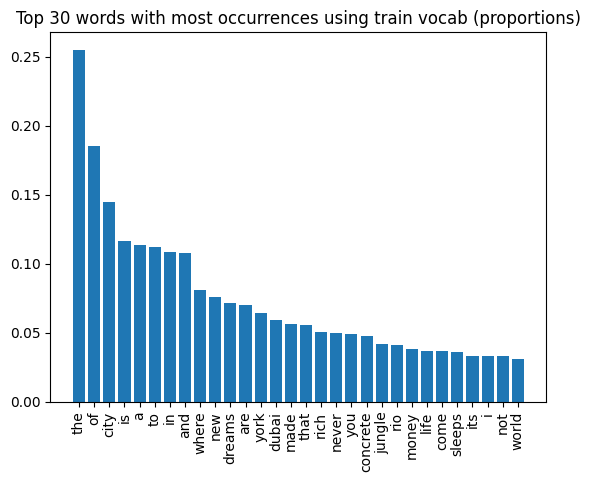

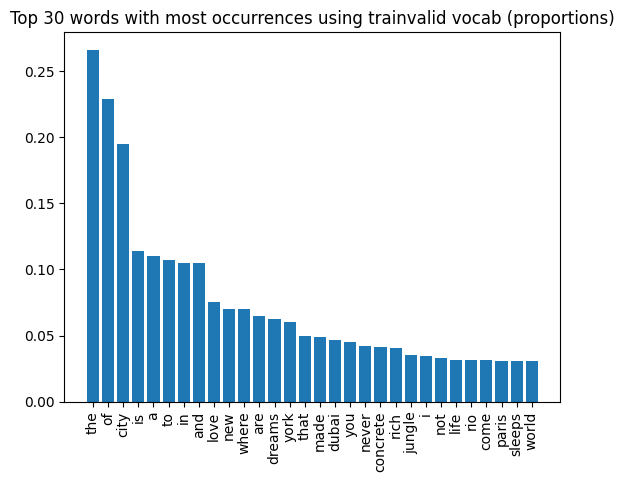

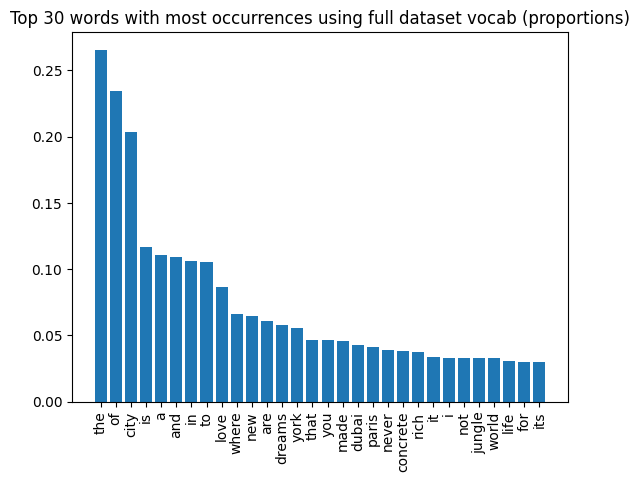

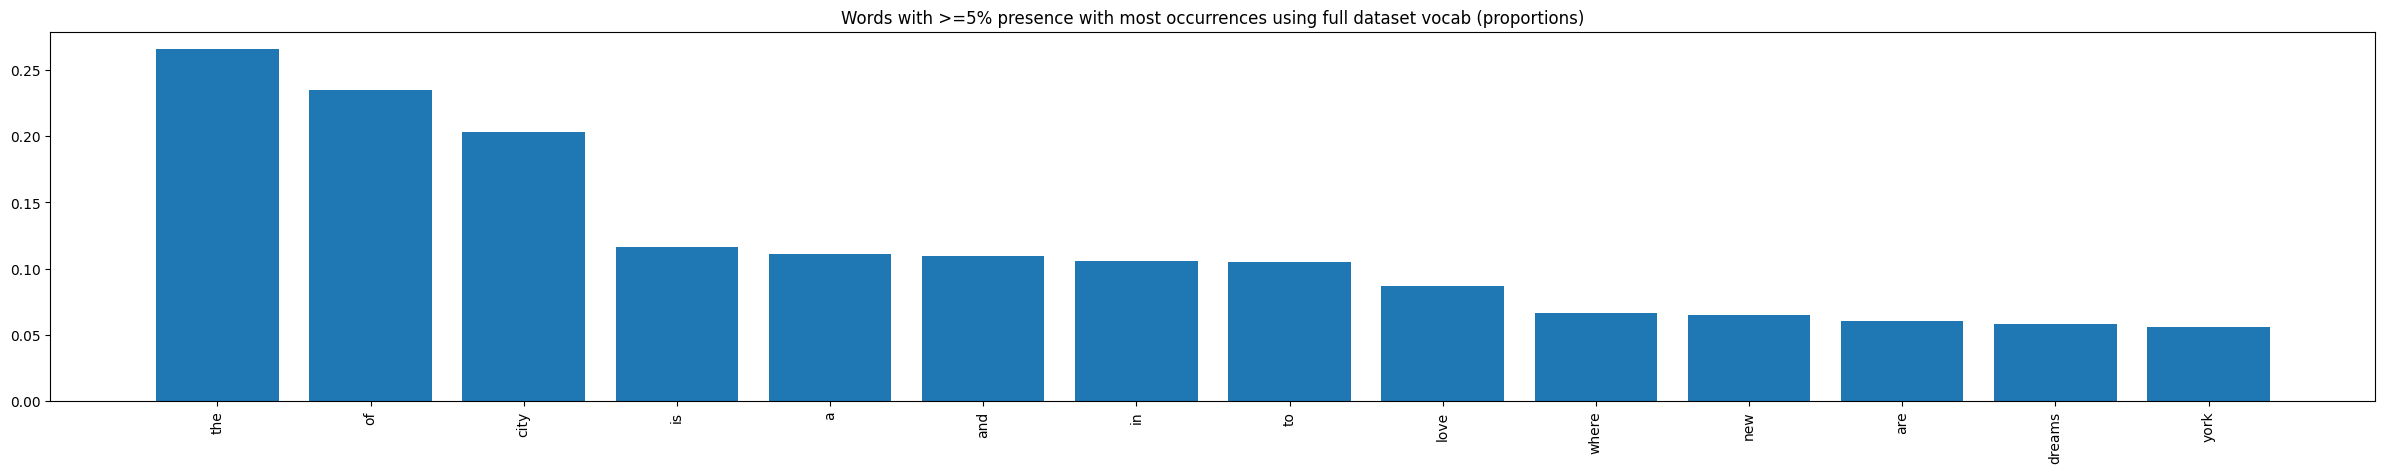

In [21]:
import random

# Some constants so I don't forget how we split the data
TRAIN_SLICE = 1024
TRAINVALID_SLICE = 1316
VALID_SLICE = TRAIN_SLICE + 292  # the actual slice will be [TRAIN_SLICE:VALID_SLICE]

def _which_onehot(s):
  """
    A helper function for one_hot that gives the one-hot encoding of hard-coded
    city names.

    Precondition:
    - s is one of "Dubai", "New York City", "Paris", or "Rio de Janeiro"
  """
  if s == "Dubai":
    return np.array([1,0,0,0])
  elif s == "New York City":
    return np.array([0,1,0,0])
  elif s == "Paris":
    return np.array([0,0,1,0])
  return np.array([0,0,0,1])


def one_hot(array):
    """
    A hard-coded function that converts a given array of cities into an array
    of corresponding one-hot vectors.

    Precondition:
    - Array elements must be "Dubai", "New York City", "Paris", or "Rio de Janeiro"
    """
    onehot = np.array([_which_onehot(x) for x in array])
    return onehot


def init_vocab(sentences):
  """
    Construct a vocabulary from a list of given sentences

    Precondition:
    - Sentences are cleaned
  """
  vocab = set()

  for sentence in sentences:
    words = sentence.split()
    for word in words:
      vocab = vocab.union(set([word]))

  return vocab


def make_bow(data, vocab, count_map=None):
  """
    Create the bag of words representation of some given data (a matrix whose
    columns represent sentences and their respective labels) using a specific
    vocabulary. Can optionally take a hashmap that can count the number of
    instances of each word in the vocab.

    Precondition:
    - The keys of count_map must be initialized to the words in vocab
    - data is a numpy array
  """
  # Reset count_map if provided so that multiple runs don't double count
  if count_map:
    for k in count_map.keys():
      count_map[k] = 0

  t = one_hot(data[:, 1])  # Use our helper to quickly make one-hot vectors for t
  X = np.zeros([data.shape[0], len(vocab)])  # Initialize size of X

  for n in range(t.shape[0]):
    for d in range(len(vocab)):
      if count_map: # If optional param count_map was provided, use it to store word counts
        count_map[vocab[d]] += vocab[d] in data[n,0].split()  # Remember: We are storing the number of sentence this word appears in, so we just add 1 if it in a sentence, regardless of how many times
      X[n,d] = vocab[d] in data[n,0].split()  # NOTE: This was incorrect when I didn't use split cause it was looking for any occurrence of the word in the entire sentence rather than checking word by word

  return X, t



# Initialize vocabularies
full_dataset_vocab = list(init_vocab(df_q10['Q10'].to_numpy()))
full_dataset_vocab_counts = {word: 0 for word in full_dataset_vocab}
full_dataset_VOCAB_SIZE = len(full_dataset_vocab)

train_vocab = list(init_vocab(df_q10['Q10'].to_numpy()[0:TRAIN_SLICE]))
train_vocab_counts = {word: 0 for word in train_vocab}
train_VOCAB_SIZE = len(train_vocab)

trainvalid_vocab = list(init_vocab(df_q10['Q10'].to_numpy()[0:TRAINVALID_SLICE]))
trainvalid_vocab_counts = {word: 0 for word in trainvalid_vocab}
trainvalid_VOCAB_SIZE = len(trainvalid_vocab)

print(f"Our vocabulary (full dataset) has {full_dataset_VOCAB_SIZE} words")
print(f"Our vocabulary (training data sliced 0:{TRAIN_SLICE}) has {train_VOCAB_SIZE} words")
print(f"Our vocabulary (training + validation data sliced 0:{TRAINVALID_SLICE}) has {trainvalid_VOCAB_SIZE} words")
print()


# Start with counting on just the training vocab
q10_data = df_q10.to_numpy()
X_train, t_train = make_bow(q10_data[0:TRAIN_SLICE,:], train_vocab, count_map=train_vocab_counts)  # Make bag of words and store counts of word for graphing purposes

# Turn the dict into a list to process easily
list_vocab_counts = [(k,v) for k,v in list(train_vocab_counts.items())]

# Sort and get the top words with most occurrences
list_vocab_counts.sort(key=lambda x: x[1], reverse=True)
subset = list_vocab_counts[:30]  # Get top ? more entries
subset = [(x[0], x[1]/X_train.shape[0]) for x in subset]  # comment out if raw counts are wanted

# Setup chart
fig, ax = plt.subplots()
ax.bar(range(len(subset)), [t[1] for t in subset], align="center")
ax.set_xticks(range(len(subset)))
ax.set_xticklabels([t[0] for t in subset])
plt.xticks(rotation=90)  # Make labels easier to read
#plt.title("Top 20 words with most occurrences in training data (counts)")
plt.title("Top 30 words with most occurrences using train vocab (proportions)")

plt.show()


# Now doing this for trainvalid
X_train, t_train = make_bow(q10_data[0:TRAINVALID_SLICE,:], trainvalid_vocab, count_map=trainvalid_vocab_counts)
list_vocab_counts = [(k,v) for k,v in list(trainvalid_vocab_counts.items())]
list_vocab_counts.sort(key=lambda x: x[1], reverse=True)
subset = list_vocab_counts[:30]
subset = [(x[0], x[1]/X_train.shape[0]) for x in subset]
fig, ax = plt.subplots()
ax.bar(range(len(subset)), [t[1] for t in subset], align="center")
ax.set_xticks(range(len(subset)))
ax.set_xticklabels([t[0] for t in subset])
plt.xticks(rotation=90)
plt.title("Top 30 words with most occurrences using trainvalid vocab (proportions)")

plt.show()


# Now doing this for whole set
X_train, t_train = make_bow(q10_data, full_dataset_vocab, count_map=full_dataset_vocab_counts)
list_vocab_counts = [(k,v) for k,v in list(full_dataset_vocab_counts.items())]
list_vocab_counts.sort(key=lambda x: x[1], reverse=True)

#subset = []  # This approach (attempts) to get all words that make up more than 1% of the observed data
#for i in range(len(list_vocab_counts)):
#  if list_vocab_counts[i][1]/X_train.shape[0] < 0.01:
#    break
#  subset.append((list_vocab_counts[i][0], (list_vocab_counts[i][1]/X_train.shape[0])))

subset = list_vocab_counts[:30]
subset = [(x[0], x[1]/X_train.shape[0]) for x in subset]
fig, ax = plt.subplots()
ax.bar(range(len(subset)), [t[1] for t in subset], align="center") # Proportion
#fig.set_figwidth(30)
ax.set_xticks(range(len(subset)))
ax.set_xticklabels([t[0] for t in subset])
plt.xticks(rotation=90)
plt.title("Top 30 words with most occurrences using full dataset vocab (proportions)")
#plt.title("Words with >=1% presence with most occurrences using full dataset vocab (proportions)")

plt.show()


# SAME GRAPH AS THE ONE IMMEDIATELY ABOVE BUT WITH CUTOFF 5%
subset = []  # This approach (attempts) to get all words that make up more than 5% of the observed data
for i in range(len(list_vocab_counts)):
  if list_vocab_counts[i][1]/X_train.shape[0] < 0.05:
    break
  subset.append((list_vocab_counts[i][0], (list_vocab_counts[i][1]/X_train.shape[0])))

# subset = list_vocab_counts[:30]
fig, ax = plt.subplots()
#ax.bar(range(len(subset)), [t[1] for t in subset], align="center") # Raw count
ax.bar(range(len(subset)), [t[1] for t in subset], align="center") # Proportion
fig.set_figwidth(30)
ax.set_xticks(range(len(subset)))
ax.set_xticklabels([t[0] for t in subset])
plt.xticks(rotation=90)
#plt.title("Top 20 words with most occurrences using full dataset vocab (proportions)")
plt.title("Words with >=5% presence with most occurrences using full dataset vocab (proportions)")

plt.show()

Most of these words aren't very informative; the presence of 'the' for example does not provide any information about the kind of sentence we may have. For a measure of "usefulness", we look at words that are not "grammatical constructs" (if that is the right word).

We start with the name of the cities. A strong presence of the word means the feature is reliable (it can help us with predictions more often). If these percentages are low, then it is not a common enough feature of the sentence to completely base a prediction off of.

In [8]:
# Looking at how often the name of the city appears in quotes

dubai = df_q10[df_q10['Label'] == 'Dubai']
n_dubai = dubai.shape[0]
n_dubai_with_word = dubai[dubai['Q10'].str.contains("dubai")].shape[0]
print(f"{round((n_dubai_with_word/n_dubai) * 100)}% entries \
that were classified as Dubai have the word 'dubai' in their quote.")

newyork = df_q10[df_q10['Label'] == 'New York City']
n_newyork = newyork.shape[0]
n_newyork_with_word = newyork[newyork['Q10'].str.contains("york")].shape[0]
print(f"{round((n_newyork_with_word/n_newyork) * 100)}% entries \
that were classified as New York have the word 'york' in their quote.")

paris = df_q10[df_q10['Label'] == 'Paris']
n_paris = paris.shape[0]
n_paris_with_word = paris[paris['Q10'].str.contains("paris")].shape[0]
print(f"{round((n_paris_with_word/n_paris) * 100)}% entries \
that were classified as Paris have the word 'paris' in their quote.")

rio = df_q10[df_q10['Label'] == 'Rio de Janeiro']
n_rio = rio.shape[0]
n_rio_with_word = rio[rio['Q10'].str.contains("rio")].shape[0]
print(f"{round((n_rio_with_word/n_rio) * 100)}% entries \
that were classified as Rio have the word 'rio' in their quote.")

17% entries that were classified as Dubai have the word 'dubai' in their quote.
24% entries that were classified as New York have the word 'york' in their quote.
17% entries that were classified as Paris have the word 'paris' in their quote.
13% entries that were classified as Rio have the word 'rio' in their quote.


It is trivial that the name of the city *only* occurs in quotes related to that city. We would not expect to see "Paris" in a quote about Dubai. We can double check this:

In [9]:
newyork = df_q10[df_q10['Label'] == 'New York City']
n_newyork = newyork.shape[0]
n_newyork_with_word = newyork[newyork['Q10'].str.contains("dubai")].shape[0]
print(f"{(n_newyork_with_word/n_newyork) * 100}% entries \
that were classified as New York have the word 'dubai' in their quote.")

paris = df_q10[df_q10['Label'] == 'Paris']
n_paris = paris.shape[0]
n_paris_with_word = paris[paris['Q10'].str.contains("dubai")].shape[0]
print(f"{(n_paris_with_word/n_paris) * 100}% entries \
that were classified as Paris have the word 'dubai' in their quote.")

rio = df_q10[df_q10['Label'] == 'Rio de Janeiro']
n_rio = rio.shape[0]
n_rio_with_word = rio[rio['Q10'].str.contains("dubai")].shape[0]
print(f"{(n_rio_with_word/n_rio) * 100}% entries \
that were classified as Rio have the word 'dubai' in their quote.")

0.0% entries that were classified as New York have the word 'dubai' in their quote.
0.0% entries that were classified as Paris have the word 'dubai' in their quote.
0.0% entries that were classified as Rio have the word 'dubai' in their quote.


Just for one city, we can see that the percentage that its name encounters in other cities' quotes is zero (without rounding).

Now for words that actually occur commonly, we can check what kind of inferences they make. If a feature occurs commonly in the data, it means that it is more reliable. We choose "dreams", "love", and "concrete". Note that these words itself make up at most 7% of all quotes in the dataset, but it would still help to see their associations with certain cities.

In [10]:
# Looking at associations of other "more useful" words
# So "the" is not included but "love" is as an example

city = df_q10[df_q10['Q10'].str.contains("city")]
n_city = city.shape[0]
city_in_dubai = city[city['Label'] == "Dubai"]
city_in_newyork = city[city['Label'] == "New York City"]
city_in_paris = city[city['Label'] == "Paris"]
city_in_rio = city[city['Label'] == "Rio de Janeiro"]

print(f"The word 'city' is distributed among the four categories as follows:")
print(f"- Dubai: {(city_in_dubai.shape[0]/n_city) * 100}%")
print(f"- New York City: {(city_in_newyork.shape[0]/n_city) * 100}%")
print(f"- Paris: {(city_in_paris.shape[0]/n_city) * 100}%")
print(f"- Rio de Janeiro: {(city_in_rio.shape[0])/n_city * 100}%")

print()
print()


dreams = df_q10[df_q10['Q10'].str.contains("dreams")]
n_dreams = dreams.shape[0]
dreams_in_dubai = dreams[dreams['Label'] == "Dubai"]
dreams_in_newyork = dreams[dreams['Label'] == "New York City"]
dreams_in_paris = dreams[dreams['Label'] == "Paris"]
dreams_in_rio = dreams[dreams['Label'] == "Rio de Janeiro"]

print(f"The word 'dreams' is distributed among the four categories as follows:")
print(f"- Dubai: {(dreams_in_dubai.shape[0]/n_dreams) * 100}%")
print(f"- New York City: {(dreams_in_newyork.shape[0]/n_dreams) * 100}%")
print(f"- Paris: {(dreams_in_paris.shape[0]/n_dreams) * 100}%")
print(f"- Rio de Janeiro: {(dreams_in_rio.shape[0])/n_dreams * 100}%")

print()
print()

love = df_q10[df_q10['Q10'].str.contains("love")]
n_love = love.shape[0]
love_in_dubai = love[love['Label'] == "Dubai"]
love_in_newyork = love[love['Label'] == "New York City"]
love_in_paris = love[love['Label'] == "Paris"]
love_in_rio = love[love['Label'] == "Rio de Janeiro"]

print(f"The word 'love' is distributed among the four categories as follows:")
print(f"- Dubai: {(love_in_dubai.shape[0]/n_love) * 100}%")
print(f"- New York City: {(love_in_newyork.shape[0]/n_love) * 100}%")
print(f"- Paris: {(love_in_paris.shape[0]/n_love) * 100}%")
print(f"- Rio de Janeiro: {(love_in_rio.shape[0])/n_love * 100}%")

print()
print()

concrete = df_q10[df_q10['Q10'].str.contains("concrete")]
n_concrete = concrete.shape[0]
concrete_in_dubai = concrete[concrete['Label'] == "Dubai"]
concrete_in_newyork = concrete[concrete['Label'] == "New York City"]
concrete_in_paris = concrete[concrete['Label'] == "Paris"]
concrete_in_rio = concrete[concrete['Label'] == "Rio de Janeiro"]

print(f"The word 'concrete' is distributed among the four categories as follows:")
print(f"- Dubai: {(concrete_in_dubai.shape[0]/n_concrete) * 100}%")
print(f"- New York City: {(concrete_in_newyork.shape[0]/n_concrete) * 100}%")
print(f"- Paris: {(concrete_in_paris.shape[0]/n_concrete) * 100}%")
print(f"- Rio de Janeiro: {(concrete_in_rio.shape[0])/n_concrete * 100}%")

print()
print()

rich = df_q10[df_q10['Q10'].str.contains("rich")]
n_rich = rich.shape[0]
rich_in_dubai = rich[rich['Label'] == "Dubai"]
rich_in_newyork = rich[rich['Label'] == "New York City"]
rich_in_paris = rich[rich['Label'] == "Paris"]
rich_in_rio = rich[rich['Label'] == "Rio de Janeiro"]

print(f"The word 'rich' is distributed among the four categories as follows:")
print(f"- Dubai: {(rich_in_dubai.shape[0]/n_rich) * 100}%")
print(f"- New York City: {(rich_in_newyork.shape[0]/n_rich) * 100}%")
print(f"- Paris: {(rich_in_paris.shape[0]/n_rich) * 100}%")
print(f"- Rio de Janeiro: {(rich_in_rio.shape[0])/n_rich * 100}%")

The word 'city' is distributed among the four categories as follows:
- Dubai: 15.517241379310345%
- New York City: 24.82758620689655%
- Paris: 46.206896551724135%
- Rio de Janeiro: 13.448275862068964%


The word 'dreams' is distributed among the four categories as follows:
- Dubai: 7.317073170731707%
- New York City: 90.2439024390244%
- Paris: 0.0%
- Rio de Janeiro: 2.4390243902439024%


The word 'love' is distributed among the four categories as follows:
- Dubai: 1.6129032258064515%
- New York City: 4.032258064516129%
- Paris: 87.09677419354838%
- Rio de Janeiro: 7.258064516129033%


The word 'concrete' is distributed among the four categories as follows:
- Dubai: 0.0%
- New York City: 100.0%
- Paris: 0.0%
- Rio de Janeiro: 0.0%


The word 'rich' is distributed among the four categories as follows:
- Dubai: 89.28571428571429%
- New York City: 5.357142857142857%
- Paris: 1.7857142857142856%
- Rio de Janeiro: 3.571428571428571%


We observe that when we see the word "love", it is a lot more likely to be in Paris than in other cities. Let's have a look at how likely the word "love" is to occur in ALL quotes classified as Paris.

In [11]:
paris = df_q10[df_q10['Label'] == 'Paris']
n_paris = paris.shape[0]
n_paris_with_word = paris[paris['Q10'].str.contains("love")].shape[0]
print(f"{round((n_paris_with_word/n_paris) * 100)}% entries \
that were classified as Paris have the word 'love' in their quote.")

newyork = df_q10[df_q10['Label'] == 'New York City']
n_newyork = newyork.shape[0]
n_newyork_with_word = newyork[newyork['Q10'].str.contains("concrete")].shape[0]
print(f"{round((n_newyork_with_word/n_newyork) * 100)}% entries \
that were classified as New York have the word 'concrete' in their quote.")

31% entries that were classified as Paris have the word 'love' in their quote.
15% entries that were classified as New York have the word 'concrete' in their quote.


# Making Predictions (scikit-learn)

Note that our bag of words just indicates whether a word is present in a sentence or not. We are not looking at word counts (since most of our quotes are not very long). This is why we use a Bernoulli Naive Bayes model compared to a Multinomial one.

Now I will define the $N \times D$ data matrix `X`, the $N \times K$ target matrix `t`, and split into training, validation, and test set accordingly.

In total, we have 1416 items. Our split is as follows:
	- X_train: 1024 (72.32%)
	- X_valid: 292 (20.62%)
	- X_test: 100 (7.06%)



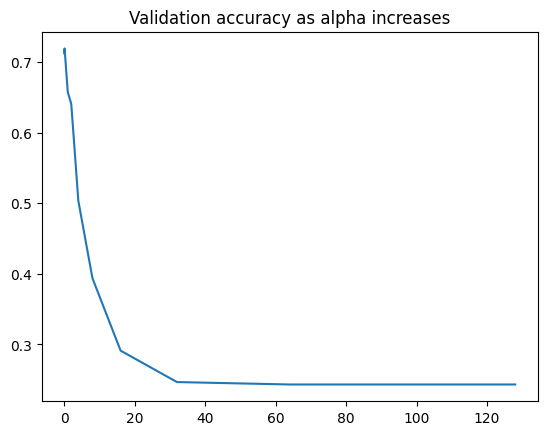


The best alpha value is 0.1
The average validation accuracy is 0.7284246575342467
The average test accuracy is 0.688


In [99]:
from sklearn.naive_bayes import BernoulliNB

def accuracy(y, t):
  return np.mean(y == t)

def get_num_from_onehot(arr):
  return [index+1 for index, item in enumerate(arr) if item == 1][0]


# Initialize data split
q10_data = df_q10.sample(frac=1).to_numpy()  # Shuffle

# Separate test data so that we can jumble training and validation set without worry
q10_trainvalid_data = q10_data[:VALID_SLICE,:]
q10_test_data = q10_data[VALID_SLICE:,:]
X_test, t_test = make_bow(q10_test_data, train_vocab)
t_test_copy = np.apply_along_axis(get_num_from_onehot, 1, t_test)

# Initialize training and valid set
X_train, t_train = make_bow(q10_trainvalid_data[:TRAIN_SLICE,:], train_vocab)
X_valid, t_valid = make_bow(q10_trainvalid_data[TRAIN_SLICE:,:], train_vocab)
t_train_copy = np.apply_along_axis(get_num_from_onehot, 1, t_train)
t_valid_copy = np.apply_along_axis(get_num_from_onehot, 1, t_valid)

# Just printing out some information about the split
print(f"In total, we have {q10_data.shape[0]} items. Our split is as follows:")
print(f"\t- X_train: {X_train.shape[0]} ({round((X_train.shape[0]/q10_data.shape[0]) * 100, 2)}%)")
print(f"\t- X_valid: {X_valid.shape[0]} ({round((X_valid.shape[0]/q10_data.shape[0]) * 100, 2)}%)")
print(f"\t- X_test: {X_test.shape[0]} ({round((X_test.shape[0]/q10_data.shape[0]) * 100, 2)}%)")
print()


# Optimize the hyperparameter alpha, which defines the strenght of Laplace Smoothing
alpha_vals = [10 ** i for i in [-2, -1]] + [2**i for i in range(8)]  # Go up by powers of two
# NOTE: SKLearn's default is 1, and while we could go lower than 10^-2, their
# documentation suggests taht values very close to 0 can give numerical errors.


best_alpha, best_acc = None, None
valid_accs = []
# Loop over all possible alpha values and see which one gives us the best validation accuracy
for alpha in alpha_vals:
  model = BernoulliNB(alpha=alpha, force_alpha = True)
  model.fit(X_train, t_train_copy)
  #y_train = model.predict(X_train)
  y_valid = model.predict(X_valid)

  #train_acc = accuracy(y_train, t_train_copy)
  valid_acc = accuracy(y_valid, t_valid_copy)
  valid_accs.append(valid_acc)

  if not best_acc or valid_acc > best_acc:  # Initialize or replace if needed
    best_acc = valid_acc
    best_alpha = alpha

# Plot validation accuracy of each alpha score
plt.plot(alpha_vals, valid_accs)
plt.title("Validation accuracy as alpha increases")
plt.show()

# Get average validation and test accuracy for best alpha
run_valid_sum = 0
run_test_sum = 0
RUNS = 10

for i in range(RUNS):
  model = BernoulliNB(alpha=best_alpha, force_alpha = True)
  model.fit(X_train, t_train_copy)
  y_valid = model.predict(X_valid)
  y_test = model.predict(X_test)

  run_valid_sum += accuracy(t_valid_copy, y_valid)
  run_test_sum += accuracy(t_test_copy, y_test)

  np.random.shuffle(q10_trainvalid_data)
  X_train, t_train = make_bow(q10_trainvalid_data[:TRAIN_SLICE,:], train_vocab)
  X_valid, t_valid = make_bow(q10_trainvalid_data[TRAIN_SLICE:,:], train_vocab)
  t_train_copy = np.apply_along_axis(get_num_from_onehot, 1, t_train)
  t_valid_copy = np.apply_along_axis(get_num_from_onehot, 1, t_valid)


avg_valid_acc = run_valid_sum/RUNS
avg_test_acc = run_test_sum/RUNS

print()
print(f"The best alpha value is {best_alpha}")
print(f"The average validation accuracy is {avg_valid_acc}")
print(f"The average test accuracy is {avg_test_acc}")

In [159]:
# Initialize data split
q10_data = df_q10.sample(frac=1).to_numpy()  # Shuffle

# Separate test data so that we can jumble training and validation set without worry
q10_trainvalid_data = q10_data[:VALID_SLICE,:]
q10_test_data = q10_data[VALID_SLICE:,:]
X_test, t_test = make_bow(q10_test_data, full_dataset_vocab)
t_test_copy = np.apply_along_axis(get_num_from_onehot, 1, t_test)

# Initialize training and valid set
X_train, t_train = make_bow(q10_trainvalid_data[:TRAIN_SLICE,:], full_dataset_vocab)
X_valid, t_valid = make_bow(q10_trainvalid_data[TRAIN_SLICE:,:], full_dataset_vocab)
t_train_copy = np.apply_along_axis(get_num_from_onehot, 1, t_train)
t_valid_copy = np.apply_along_axis(get_num_from_onehot, 1, t_valid)

# Just printing out some information about the split
print(f"In total, we have {q10_data.shape[0]} items. Our split is as follows:")
print(f"\t- X_train: {X_train.shape[0]} ({round((X_train.shape[0]/q10_data.shape[0]) * 100, 2)}%)")
print(f"\t- X_valid: {X_valid.shape[0]} ({round((X_valid.shape[0]/q10_data.shape[0]) * 100, 2)}%)")
print(f"\t- X_test: {X_test.shape[0]} ({round((X_test.shape[0]/q10_data.shape[0]) * 100, 2)}%)")
print()


# Optimize the hyperparameter alpha, which defines the strenght of Laplace Smoothing
alpha_vals = [10 ** i for i in [-2, -1]] + [2**i for i in range(8)]  # Go up by powers of two
# NOTE: SKLearn's default is 1, and while we could go lower than 10^-2, their
# documentation suggests taht values very close to 0 can give numerical errors.


best_alpha, best_acc = None, None

# Loop over all possible alpha values and see which one gives us the best validation accuracy
for alpha in alpha_vals:
  model = BernoulliNB(alpha=alpha, force_alpha = False)
  model.fit(X_train, t_train_copy)
  #y_train = model.predict(X_train)
  y_valid = model.predict(X_valid)

  #train_acc = accuracy(y_train, t_train_copy)
  valid_acc = accuracy(y_valid, t_valid_copy)

  if not best_acc or valid_acc > best_acc:  # Initialize or replace if needed
    best_acc = valid_acc
    best_alpha = alpha

# Get average validation and test accuracy for best alpha
run_valid_sum = 0
run_test_sum = 0
RUNS = 10

for i in range(RUNS):
  model = BernoulliNB(alpha=best_alpha, force_alpha = False)
  model.fit(X_train, t_train_copy)
  y_valid = model.predict(X_valid)
  y_test = model.predict(X_test)

  run_valid_sum += accuracy(t_valid_copy, y_valid)
  run_test_sum += accuracy(t_test_copy, y_test)

  np.random.shuffle(q10_trainvalid_data)
  X_train, t_train = make_bow(q10_trainvalid_data[:TRAIN_SLICE,:], full_dataset_vocab)
  X_valid, t_valid = make_bow(q10_trainvalid_data[TRAIN_SLICE:,:], full_dataset_vocab)
  t_train_copy = np.apply_along_axis(get_num_from_onehot, 1, t_train)
  t_valid_copy = np.apply_along_axis(get_num_from_onehot, 1, t_valid)


avg_valid_acc = run_valid_sum/RUNS
avg_test_acc = run_test_sum/RUNS

print()
print(f"The best alpha value is {best_alpha}")
print(f"The average validation accuracy is {avg_valid_acc}")
print(f"The average test accuracy is {avg_test_acc}")

In total, we have 1416 items. Our split is as follows:
	- X_train: 1024 (72.32%)
	- X_valid: 292 (20.62%)
	- X_test: 100 (7.06%)


The best alpha value is 0.1
The average validation accuracy is 0.7784246575342466
The average test accuracy is 0.8469999999999999


With a trained model, we can examine the conditional probabilities $P(w | c)$ for each word in the vocabulary. Let's look at the words with the highest probabilities for each category...

In [160]:
MIN_PROB = 0.05  # cutoff

# Get conditional probs from model
dubai_prob = np.exp(model.feature_log_prob_[0, :])
nyc_prob = np.exp(model.feature_log_prob_[1, :])
paris_prob = np.exp(model.feature_log_prob_[2, :])
rio_prob = np.exp(model.feature_log_prob_[3, :])

dubai_zipped = list(zip(full_dataset_vocab, dubai_prob))
dubai_sorted_zip = sorted(dubai_zipped, key=lambda x: x[1], reverse=True)
dubai_final = [x for x in dubai_sorted_zip if x[1] > MIN_PROB]
print("Below are all the sorted word probabilities that occur for words that would be categorized as Dubai")
print(dubai_final)
print()

nyc_zipped = list(zip(full_dataset_vocab, nyc_prob))
nyc_sorted_zip = sorted(nyc_zipped, key=lambda x: x[1], reverse=True)
nyc_final = [x for x in nyc_sorted_zip if x[1] > MIN_PROB]
print("Below are all the sorted word probabilities that occur for words that would be categorized as New York City")
print(nyc_final)
print()

paris_zipped = list(zip(full_dataset_vocab, paris_prob))
paris_sorted_zip = sorted(paris_zipped, key=lambda x: x[1], reverse=True)
paris_final = [x for x in paris_sorted_zip if x[1] > MIN_PROB]
print("Below are all the sorted word probabilities that occur for words that would be categorized as Paris")
print(paris_final)
print()

rio_zipped = list(zip(full_dataset_vocab, rio_prob))
rio_sorted_zip = sorted(rio_zipped, key=lambda x: x[1], reverse=True)
rio_final = [x for x in rio_sorted_zip if x[1] > MIN_PROB]
print("Below are all the sorted word probabilities that occur for words that would be categorized as Rio de Janeiro")
print(rio_final)

Below are all the sorted word probabilities that occur for words that would be categorized as Dubai
[('the', 0.3063516653756779), ('is', 0.16692486444616575), ('dubai', 0.16692486444616575), ('to', 0.16305189775367934), ('of', 0.15143299767621998), ('and', 0.13206816421378778), ('rich', 0.12819519752130137), ('a', 0.12819519752130137), ('city', 0.12432223082881491), ('money', 0.11270333075135557), ('in', 0.10108443067389623), ('habibi', 0.06235476374903176), ('come', 0.06235476374903176), ('not', 0.05460883036405888), ('world', 0.05073586367157242)]

Below are all the sorted word probabilities that occur for words that would be categorized as New York City
[('of', 0.27941176470588247), ('the', 0.26055806938159887), ('new', 0.25678733031674217), ('york', 0.23039215686274514), ('dreams', 0.20776772247360487), ('city', 0.1889140271493213), ('made', 0.1813725490196079), ('where', 0.1813725490196079), ('are', 0.1738310708898944), ('concrete', 0.16251885369532426), ('jungle', 0.1323529411764

Attempting to construct a model with the few words I chose:

Words List: `[dubai, rich, city, rio, love, dreams, paris, york, football, tower, concrete, money, baguette, brazil, carnival, jungle, eiffel, habibi, oil, big, apple]`

# Trying Bernoulli Naive Bayes on Other Features

Note that we have to binarize each question. Here are the approaches taken:
- Questions 1-4 are similar in that they are rankings. For this we can simply take a one-hot vector of size `MAX_RANKING` and set the $i$'th entry to 1 depending on what the rating was.
- Question 5 was already split into individual binary variables.
- Question 6 first has each entry "Skyscraper", "Sports", etc. have its ranking turned into its own vector, then this was made one hot. So, $\text{rank}_{i}^{p}$ represents whether the word $i$ was ranked $p$ or not.

In [90]:
fresh_data = pd.read_csv("clean_dataset.csv")
test_data = df_full.sample(frac=1)

def binarize_ranking(pd_col):
  """
    Turn a column of integers into a column of one-hot vectors

    Preconditions:
    - Column elements are not strings
    - Column elements are positive integers
  """

  return pd_col.map(lambda x: np.array([int(x == (i+1)) for i in range(max(pd_col.unique()))]))

def spread_arr(pd_df, col_name):
  """
    Unpacks a one-hot vector

    NOTE: Only call this function on a column that had binarize_ranking used on it!
  """
  n_col = len(pd_df[col_name][0])
  for i in range(1, n_col+1):
    new_name = col_name + f"_{i}"
    pd_df[new_name] = pd_df[col_name].apply(lambda x: x[i-1])

# First I convert as many features into binary as I can
test_data["Q1"] = binarize_ranking(test_data["Q1"])
test_data["Q2"] = binarize_ranking(test_data["Q2"])
test_data["Q3"] = binarize_ranking(test_data["Q3"])
test_data["Q4"] = binarize_ranking(test_data["Q4"])

test_data["Q6"] = fresh_data["Q6"].apply(get_number_list_clean)

temp_names = []
for i in range(1,7):
    col_name = f"rank_{i}"
    temp_names.append(col_name)
    test_data[col_name] = test_data["Q6"].apply(lambda l: find_area_at_rank(l, i))


for i in range(1,7):
    col_name = f"rank_{i}"
    indicators = pd.get_dummies(test_data[col_name], prefix=col_name)
    test_data = pd.concat([test_data, indicators], axis=1)
    #del test_data[col]

del test_data["Q6Skyscraper"]
del test_data["Q6ArtMusic"]
del test_data["Q6Sport"]
del test_data["Q6Carnival"]
del test_data["Q6Cuisine"]
del test_data["Q6Economic"]
del test_data["Q6"]
del test_data["Q7"]
del test_data["Q8"]
del test_data["Q9"]

#test_data_q10 = test_data[["Q10", "Label"]]
#del test_data["Q10"]

spread_arr(test_data, "Q1")
spread_arr(test_data, "Q2")
spread_arr(test_data, "Q3")
spread_arr(test_data, "Q4")
del test_data["Q1"]
del test_data["Q2"]
del test_data["Q3"]
del test_data["Q4"]
test_data = test_data.drop(temp_names, axis=1)

print(test_data.columns)
print(test_data)


Index(['Q10', 'Label', 'Q5Partner', 'Q5Friends', 'Q5Siblings', 'Q5Co-worker',
       'rank_1_0', 'rank_1_1', 'rank_1_2', 'rank_1_3', 'rank_1_4', 'rank_1_5',
       'rank_1_6', 'rank_2_0', 'rank_2_1', 'rank_2_2', 'rank_2_3', 'rank_2_4',
       'rank_2_5', 'rank_2_6', 'rank_3_0', 'rank_3_1', 'rank_3_2', 'rank_3_3',
       'rank_3_4', 'rank_3_5', 'rank_3_6', 'rank_4_0', 'rank_4_1', 'rank_4_2',
       'rank_4_3', 'rank_4_4', 'rank_4_5', 'rank_4_6', 'rank_5_0', 'rank_5_1',
       'rank_5_2', 'rank_5_3', 'rank_5_4', 'rank_5_5', 'rank_5_6', 'rank_6_0',
       'rank_6_1', 'rank_6_2', 'rank_6_3', 'rank_6_4', 'rank_6_5', 'rank_6_6',
       'Q1_1', 'Q1_2', 'Q1_3', 'Q1_4', 'Q1_5', 'Q2_1', 'Q2_2', 'Q2_3', 'Q2_4',
       'Q2_5', 'Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q4_1', 'Q4_2', 'Q4_3',
       'Q4_4', 'Q4_5'],
      dtype='object')
                                                    Q10           Label  \
288             i think this city is great and gorgeous           Dubai   
156            


The best alpha value is 1
The average validation accuracy is 0.8931506849315067
The average test accuracy is 0.873


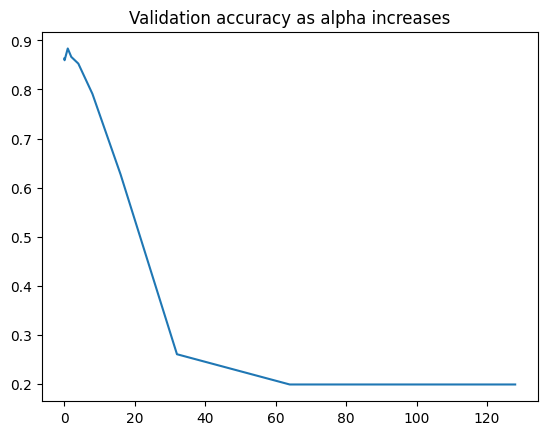

In [151]:
def num_encode(x):
  map = {"Dubai": 1, "New York City": 2, "Paris": 3, "Rio de Janeiro": 4}
  return map[x]

# Randomize for sanity
randomized = test_data.sample(frac=1)
randomized_trainvalid = randomized.iloc[:VALID_SLICE]
randomized_test = randomized.iloc[VALID_SLICE:]

# Start with defining test set
X_test, t_test = randomized_test.drop(["Label", "Q10"], axis=1).to_numpy(), randomized_test["Label"].to_numpy()
t_test_copy = np.array([num_encode(x) for x in t_test])
X_test_bow, _ = make_bow(randomized_test[["Q10", "Label"]].to_numpy(), train_vocab)
X_test = np.hstack((X_test, X_test_bow))

# Start with getting the bulk of the data (Q1-5,6)
X, t = randomized_trainvalid.drop(["Label", "Q10"], axis=1).to_numpy(), randomized_trainvalid["Label"].to_numpy()
X_train, X_valid = X[:TRAIN_SLICE], X[TRAIN_SLICE:]
t_train, t_valid = t[:TRAIN_SLICE], t[TRAIN_SLICE:]

# SKLearn does not like one-hot encoded target labels
t_train_copy = np.array([num_encode(x) for x in t_train])
t_valid_copy = np.array([num_encode(x) for x in t_valid])

# Now, get the bag of words data using our custom vocab
X_train_bow, _ = make_bow(randomized_trainvalid[["Q10", "Label"]].to_numpy()[:TRAIN_SLICE], train_vocab)
X_valid_bow, _ = make_bow(randomized_trainvalid[["Q10", "Label"]].to_numpy()[TRAIN_SLICE:], train_vocab)

# Append the bag of words data onto our other cleaned data
X_train = np.hstack((X_train, X_train_bow))
X_valid = np.hstack((X_valid, X_valid_bow))


# Optimize the hyperparameter alpha, which defines the strenght of Laplace Smoothing
alpha_vals = [10 ** i for i in [-2, -1]] + [2**i for i in range(8)]  # Go up by powers of two
# NOTE: SKLearn's default is 1, and while we could go lower than 10^-2, their
# documentation suggests taht values very close to 0 can give numerical errors.

best_alpha, best_acc = None, None
valid_accs = []
# Loop over all possible alpha values and see which one gives us the best validation accuracy
for alpha in alpha_vals:
  model = BernoulliNB(alpha=alpha, force_alpha = True)
  model.fit(X_train, t_train_copy)
  #y_train = model.predict(X_train)
  y_valid = model.predict(X_valid)

  #train_acc = accuracy(y_train, t_train_copy)

  valid_acc = accuracy(y_valid, t_valid_copy)
  valid_accs.append(valid_acc)

  if not best_acc or valid_acc > best_acc:  # Initialize or replace if needed
    best_acc = valid_acc
    best_alpha = alpha



# Now get average validation and test accuracy
run_valid_sum = 0
run_test_sum = 0
RUNS = 10

for i in range(RUNS):
  model = BernoulliNB(alpha=best_alpha, force_alpha = True)
  model.fit(X_train, t_train_copy)
  y_valid = model.predict(X_valid)
  y_test = model.predict(X_test)

  run_valid_sum += accuracy(t_valid_copy, y_valid)
  run_test_sum += accuracy(t_test_copy, y_test)

  # Start with getting the bulk of the data (Q1-5,6)
  randomized_trainvalid = randomized_trainvalid.sample(frac=1)
  X, t = randomized_trainvalid.drop(["Label", "Q10"], axis=1).to_numpy(), randomized_trainvalid["Label"].to_numpy()
  X_train, X_valid = X[:TRAIN_SLICE], X[TRAIN_SLICE:]
  t_train, t_valid = t[:TRAIN_SLICE], t[TRAIN_SLICE:]

  # SKLearn does not like one-hot encoded target labels
  t_train_copy = np.array([num_encode(x) for x in t_train])
  t_valid_copy = np.array([num_encode(x) for x in t_valid])

  # Now, get the bag of words data using our custom vocab
  X_train_bow, _ = make_bow(randomized_trainvalid[["Q10", "Label"]].to_numpy()[:TRAIN_SLICE], train_vocab)
  X_valid_bow, _ = make_bow(randomized_trainvalid[["Q10", "Label"]].to_numpy()[TRAIN_SLICE:], train_vocab)

  # Append the bag of words data onto our other cleaned data
  X_train = np.hstack((X_train, X_train_bow))
  X_valid = np.hstack((X_valid, X_valid_bow))


avg_valid_acc = run_valid_sum/RUNS
avg_test_acc = run_test_sum/RUNS

print()
print(f"The best alpha value is {best_alpha}")
print(f"The average validation accuracy is {avg_valid_acc}")
print(f"The average test accuracy is {avg_test_acc}")

# Plot validation accuracy of each alpha score
plt.plot(alpha_vals, valid_accs)
plt.title("Validation accuracy as alpha increases")
plt.show()



# Now use SKLearn's BernoulliNB to make predictions
#model = BernoulliNB()
#model = BernoulliNB(alpha=best_alpha, force_alpha=False)
#model.fit(X_train, t_train_copy)
#y_train = model.predict(X_train)
#y_valid = model.predict(X_valid)

In [158]:
def num_encode(x):
  map = {"Dubai": 1, "New York City": 2, "Paris": 3, "Rio de Janeiro": 4}
  return map[x]

# Manually taking some popular words from our observations (yields better performance)
custom_vocab = ["dubai", "rich", "city", "rio", "love", "dreams", "paris", "york", "football", "tower", "concrete", "money", "baguette", "brazil", "carnival", "jungle", "eiffel", "habibi", "oil", "big", "apple"]

# Programmatically generate a vocabulary using the subsets of words we generated
#custom_vocab = set([x[0] for x in dubai_final])
#temp1 = set([x[0] for x in nyc_final])
#temp2 = set([x[0] for x in paris_final])
#temp3 = set([x[0] for x in rio_final])
#custom_vocab = custom_vocab.union(temp1)
#custom_vocab = custom_vocab.union(temp2)
#custom_vocab = list(custom_vocab.union(temp3))

# Randomize for sanity
randomized = test_data.sample(frac=1)
randomized_trainvalid = randomized.iloc[:VALID_SLICE]
randomized_test = randomized.iloc[VALID_SLICE:]

# Start with defining test set
X_test, t_test = randomized_test.drop(["Label", "Q10"], axis=1).to_numpy(), randomized_test["Label"].to_numpy()
t_test_copy = np.array([num_encode(x) for x in t_test])
X_test_bow, _ = make_bow(randomized_test[["Q10", "Label"]].to_numpy(), custom_vocab)
X_test = np.hstack((X_test, X_test_bow))

# Start with getting the bulk of the data (Q1-5,6)
X, t = randomized_trainvalid.drop(["Label", "Q10"], axis=1).to_numpy(), randomized_trainvalid["Label"].to_numpy()
X_train, X_valid = X[:TRAIN_SLICE], X[TRAIN_SLICE:]
t_train, t_valid = t[:TRAIN_SLICE], t[TRAIN_SLICE:]

# SKLearn does not like one-hot encoded target labels
t_train_copy = np.array([num_encode(x) for x in t_train])
t_valid_copy = np.array([num_encode(x) for x in t_valid])

# Now, get the bag of words data using our custom vocab
X_train_bow, _ = make_bow(randomized_trainvalid[["Q10", "Label"]].to_numpy()[:TRAIN_SLICE], custom_vocab)
X_valid_bow, _ = make_bow(randomized_trainvalid[["Q10", "Label"]].to_numpy()[TRAIN_SLICE:], custom_vocab)

# Append the bag of words data onto our other cleaned data
X_train = np.hstack((X_train, X_train_bow))
X_valid = np.hstack((X_valid, X_valid_bow))

# Now use SKLearn's BernoulliNB to make predictions
#model = BernoulliNB()
model = BernoulliNB(alpha=best_alpha, force_alpha=True)
model.fit(X_train, t_train_copy)
y_train = model.predict(X_train)
y_valid = model.predict(X_valid)
y_test = model.predict(X_test)

print(f"Training accuracy: {accuracy(y_train, t_train_copy)}")
print(f"Validation accuracy: {accuracy(y_valid, t_valid_copy)}")
print(f"Test accuracy: {accuracy(y_test, t_test_copy)}")

Training accuracy: 0.880859375
Validation accuracy: 0.9041095890410958
Test accuracy: 0.88


In [140]:
def num_encode(x):
  map = {"Dubai": 1, "New York City": 2, "Paris": 3, "Rio de Janeiro": 4}
  return map[x]

# Manually taking some popular words from our observations (yields better performance)
custom_vocab = ["dubai", "rich", "city", "rio", "love", "dreams", "paris", "york", "football", "tower", "concrete", "money", "baguette", "brazil", "carnival", "jungle", "eiffel", "habibi", "oil", "big", "apple"]

# Programmatically generate a vocabulary using the subsets of words we generated
#custom_vocab = set([x[0] for x in dubai_final])
#temp1 = set([x[0] for x in nyc_final])
#temp2 = set([x[0] for x in paris_final])
#temp3 = set([x[0] for x in rio_final])
#custom_vocab = custom_vocab.union(temp1)
#custom_vocab = custom_vocab.union(temp2)
#custom_vocab = list(custom_vocab.union(temp3))

# Randomize for sanity
randomized = test_data.sample(frac=1)

# Start with getting the bulk of the data (Q1-5,6)
X, t = randomized.drop(["Label", "Q10"], axis=1).to_numpy(), randomized["Label"].to_numpy()
X_train, X_valid = X[:TRAINVALID_SLICE], X[TRAINVALID_SLICE:]
t_train, t_valid = t[:TRAINVALID_SLICE], t[TRAINVALID_SLICE:]

# SKLearn does not like one-hot encoded target labels
t_train_copy = np.array([num_encode(x) for x in t_train])
t_valid_copy = np.array([num_encode(x) for x in t_valid])

# Now, get the bag of words data using our custom vocab
Xt_bow, _ = make_bow(randomized[["Q10", "Label"]].to_numpy()[:TRAINVALID_SLICE], custom_vocab)
Xv_bow, _ = make_bow(randomized[["Q10", "Label"]].to_numpy()[TRAINVALID_SLICE:], custom_vocab)

# Append the bag of words data onto our other cleaned data
X_train = np.hstack((X_train, Xt_bow))
X_valid = np.hstack((X_valid, Xv_bow))

# Now use SKLearn's BernoulliNB to make predictions
#model = BernoulliNB()
model = BernoulliNB(alpha=1, force_alpha=True)
model.fit(X_train, t_train_copy)
y_train = model.predict(X_train)
y_valid = model.predict(X_valid)

print(f"Training accuracy: {np.mean(y_train == t_train_copy)}")
print(f"Validation accuracy: {np.mean(y_valid == t_valid_copy)}")

Training accuracy: 0.8913373860182371
Validation accuracy: 0.86


# ROUGH WORK

Currently has my attempt at using MultinomialNB (would be a brand new thing to implement anyways), and my attempt as using lab code to implement BernoulliNB myself for our case (there was a moment where I thought SKLearn wasn't playing nicely with my Bag-of-Words).

Since questions 1-4 and 6 are ranking based, I can attempt using Multinomial Naive Bayes to make predictions:

In [17]:
# Using sklearn to also transform the data this time
# Source: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, CategoricalNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

model = MultinomialNB().fit(X_train_tfidf, t_train)


# Training acc
predicted = model.predict(X_train_tfidf)
print(f"Training Accuracy: {np.mean(predicted == t_train)}")

# Now we try predicting
X_valid_counts = count_vect.transform(X_valid)
X_valid_tfidf = tfidf_transformer.transform(X_valid_counts)
predicted = model.predict(X_valid_tfidf)

print(f"Validation Accuracy: {np.mean(predicted == t_valid)}")

# Test accuracy
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
predicted = model.predict(X_test_tfidf)

print(f"Test Accuracy: {np.mean(predicted == t_test)}")


AttributeError: 'numpy.ndarray' object has no attribute 'lower'